<a href="https://colab.research.google.com/github/GuidoGiacomoMussini/Text_Mining-Lyrics_Analysis/blob/main/2-Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import string
from tqdm import tqdm as progress_bar
import pickle
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#functions
!cp /content/drive/MyDrive/Colab\ Notebooks/Text\ Mining/Utils/preprocessing.py /content
import preprocessing as PREPROCESSING

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# LYRICS

Import the data

In [ ]:
files_path = '/content/drive/MyDrive/Colab Notebooks/Text Mining/Files/'
lyrics_file = 'raw_lyrics.h5'

df =  pd.read_hdf(files_path + lyrics_file, key='data')
df.head(2)

### Clean the lyrics
* remove headers and other information inside the song that are not part of the lyrics (like the phrase 'You might also like'
* modify how the verses are represented: '\n' -> '/'

In [ ]:
df['Lyrics'] = [PREPROCESSING.clean_lyrics(PREPROCESSING.remove_headers(song)) for song in df.Lyrics]

df.head(2)

,Author,Title,Lyrics
0,Fabrizio De André,La Guerra Di Piero,Dormi sepolto in un campo di grano/ Non è la ...
1,Fabrizio De André,Don Raffaè,Io mi chiamo Pasquale Cafiero/ E son brigad...


In [ ]:
df.Lyrics[40]

### Remove outliers
* i expect to have songs with long part of prose (expecially by Giorgio Gaber), i want to delete them

derive the length of each verse inside each song

In [ ]:
df['verses'] = [song.split("/") for song in df.Lyrics]

In [ ]:
df['max_len_verses'] = [max([len(verse) for verse in song ]) for song in df.verses]
df.head()

,Author,Title,Lyrics,verses,max_len_verses
0,Fabrizio De André,La Guerra Di Piero,Dormi sepolto in un campo di grano/ Non è la ...,"[Dormi sepolto in un campo di grano, Non è l...",45
1,Fabrizio De André,Don Raffaè,Io mi chiamo Pasquale Cafiero/ E son brigad...,"[Io mi chiamo Pasquale Cafiero, E son brig...",74
2,Fabrizio De André,Dolcenera,Amìala ch'â l'arìa amìa cum'â l'é cum'â l'é/ ...,"[Amìala ch'â l'arìa amìa cum'â l'é cum'â l'é, ...",67
3,Fabrizio De André,Bocca Di Rosa,La chiamavano Bocca di Rosa/ Metteva l'amor...,"[La chiamavano Bocca di Rosa, Metteva l'am...",43
4,Fabrizio De André,Il Testamento di Tito,Non avrai altro Dio all'infuori di me/ Spess...,"[Non avrai altro Dio all'infuori di me, Spe...",44


Derive a rule to discriminate outliers

In [ ]:
#derive mean and std to find thr outliers:
k = 1 #choose k to be manage the number of data to be discarded
sup_lim = np.mean(df['max_len_verses'])+ k*np.std(df['max_len_verses'])

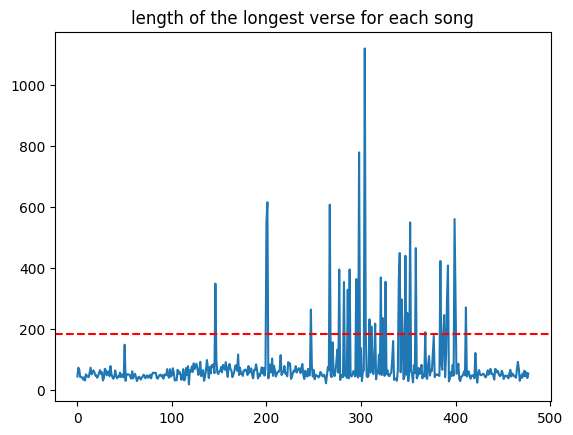

In [ ]:
plt.plot(df['max_len_verses'])
plt.axhline(y=sup_lim, color='r', linestyle='--', label='Limite Superiore')
plt.title("length of the longest verse for each song")
plt.show()

In [ ]:
len_ = len(df.Lyrics)
number_of_removed = len(df[df['max_len_verses'] <= sup_lim].reset_index(drop=True))
print(len_ - number_of_removed, "songs will be removed with k =", k)

print("we discard songs by:", Counter(df.Author[df['max_len_verses'] > sup_lim]))

34 songs will be removed with k = 1
we discard songs by: Counter({'Giorgio Gaber': 23, 'Claudio Lolli': 8, 'Francesco Guccini': 3})


Remove the outliers

In [ ]:
#34 songs to be discarded it's a good balance between the initial purpose and the dataset size:
df = df[df['max_len_verses'] <= sup_lim].reset_index(drop=True)

df = df.drop(columns = ['max_len_verses'])

In [ ]:
df.head(2)

,Author,Title,Lyrics,verses
0,Fabrizio De André,La Guerra Di Piero,Dormi sepolto in un campo di grano/ Non è la ...,"[Dormi sepolto in un campo di grano, Non è l..."
1,Fabrizio De André,Don Raffaè,Io mi chiamo Pasquale Cafiero/ E son brigad...,"[Io mi chiamo Pasquale Cafiero, E son brig..."


### Text preprocessing
* remove uppercase, punctuation, extra spaces, non ASCII chars
* Stopword removal + Lemmatization

In [ ]:
#Remove Uppercase:
df['Lyrics'] = [song.lower() for song in df.Lyrics]

#Remove Punctuation (Note that i don't remove '/' which is the char that divide the songs by verses, it will be removed after the lemmatization.)
punctuation_pattern = "[!\"#$%&()*+,-.:;<=>?@[\\]^_`{|}~]"
df.Lyrics = [PREPROCESSING.remove_punctuation(song, punctuation_pattern) for song in df.Lyrics]

#Remove Extra spaces
df.Lyrics =  [re.sub(r'\s+', ' ', song) for song in df.Lyrics]

#Trasform non italian characters: ż -> z, ñ -> n, for example.
accepted_accents = ['à', 'è', 'é', 'ì', 'ò', 'ù']
df.Lyrics = [PREPROCESSING.fix_accents(word, accepted_accents) for word in df.Lyrics]

df.head(2)

,Author,Title,Lyrics,verses
0,Fabrizio De André,La Guerra Di Piero,dormi sepolto in un campo di grano/ non è la r...,"[Dormi sepolto in un campo di grano, Non è l..."
1,Fabrizio De André,Don Raffaè,io mi chiamo pasquale cafiero/ e son brigadier...,"[Io mi chiamo Pasquale Cafiero, E son brig..."


remove non-ASCII/special characters

In [ ]:
#Delete all the characters that does not match the alphabet (like numbers and symbols)

#check the characters that i have in the lyrics
unique_char = [c for lista in df.Lyrics for c in lista]
unique_char = set(unique_char)

#store the alphabet (+ space and accents)
alphabet = list(string.ascii_lowercase) + [" ", 'à', 'è', 'é', 'ì', 'ò', 'ù', '/', "'"]

#store all the chars not in alphabet
del_char = [char for char in unique_char if char not in alphabet]

#remove char not in alphabet:
df['Lyrics'] = [PREPROCESSING.delete_chars(song, del_char) for song in df.Lyrics]

df.head(2)

,Author,Title,Lyrics,verses
0,Fabrizio De André,La Guerra Di Piero,dormi sepolto in un campo di grano/ non è la r...,"[Dormi sepolto in un campo di grano, Non è l..."
1,Fabrizio De André,Don Raffaè,io mi chiamo pasquale cafiero/ e son brigadier...,"[Io mi chiamo Pasquale Cafiero, E son brig..."


remove songs in foreign languages
* there are several methods, no one is able to delete all the songs in dialets or in foreign languages (like creuza de ma or sidun)

In [ ]:
df['language'] = [PREPROCESSING.text_language(lyric) for lyric in progress_bar(df.Lyrics)]
print("\nnumber of song deleted:", len(df[df.language != 'it']))
df = df[df.language == 'it'].reset_index(drop = True) #remove non italian lyrics
df = df.drop(columns = ['language'])

100%|██████████| 444/444 [00:03<00:00, 125.81it/s]


number of song deleted: 5


In [ ]:
df.Lyrics[40]

"quando ero piccolo m'innamoravo di tutto correvo dietro ai cani/ e da marzo a febbraio mio nonno vegliava/ sulla corrente di cavalli e di buoi/ sui fatti miei e sui fatti tuoi/ e al dio degli inglesi non credere mai/ e quando avevo duecento lune e forse qualcuna è di troppo/ rubai il primo cavallo e mi fecero uomo/ cambiai il mio nome in coda di lupo / cambiai il mio pony con un cavallo muto/ e al loro dio perdente non credere mai/ e fu nella notte della lunga stella con la coda/ che trovammo mio nonno crocifisso sulla chiesa/ crocifisso con forchette che si usano a cena/ era sporco e pulito di sangue e di crema/ e al loro dio goloso non credere mai/ e forse avevo diciott'anni e non puzzavo più di serpente/ possedevo una spranga un cappello e una fionda/ e una notte di gala con un sasso a punta/ uccisi uno smoking e glielo rubai/ e al dio della scala non credere mai/ poi tornammo in brianza per l'apertura della caccia al bisonte/ ci fecero l'esame dell'alito e delle urine/ ci spiegò i

Stopwords and Lemmatization
* Lemmatization performed using 'spacy'. From Utils you can call the function 'lemmatization_stanza' that perform lemmatization using 'stanza'. Spacy and Stanza perform overall the same, both make some mistakes in the Italian language, but Spacy has the advantage of being computationally faster

In [ ]:
#Remove stopwords
df['processed_lyrics'] = [PREPROCESSING.remove_stopwords(song) for song in df.Lyrics]

#Lemmatization (and remove extra spaces at the beginning and end of the strings)
df['processed_lyrics']= [PREPROCESSING.lemmatization_spacy(song).strip() for song in progress_bar(df.processed_lyrics)]

In [ ]:
#divide the songs and the and the pl_songs by verses
df['verses'] = [song.split("/") for song in df.Lyrics]
df['processed_verses'] = [song.split("/") for song in df.processed_lyrics]

#remove '/' from lyrics' columns
df['Lyrics']= [PREPROCESSING.delete_chars(song, "/") for song in df.Lyrics]
df['processed_lyrics']= [PREPROCESSING.delete_chars(song, "/") for song in df.processed_lyrics]

df.head()

Retrieve the POS for each verse.

In [ ]:
df['POS'] = [[PREPROCESSING.pos_tagging(verse.strip()) for verse in song] for song in progress_bar(df.verses)]

# BIBLE

import the data

In [ ]:
with open(r'/content/drive/MyDrive/Colab Notebooks/Text Mining/Files/Bibbia.txt', 'r', encoding='latin-1') as file:
    bible = file.read()

### Text preprocessing:
* lower the chars
* divide the text in 'phrases'
* remove outliers
* remove special\non-Ascii chars


In [ ]:
#lower all the letters
bible = bible.lower()

#divide the bible in verses ('versetti') which are defined by '[num]'
biblic_verses = re.split(r'\[\d+]', bible)

#remove empty strings
biblic_verses = [verse.strip() for verse in biblic_verses if verse.strip()]

biblic_verses[0:5]

In [ ]:
#since a biblic verse could be long, i further divide the verses in phrases

biblic_phrases = []
for verse in biblic_verses:
    #i define a phrase as a part of text delimitated by the punctuation ',:;."\n'
    phrases = re.split(r'[,:;."\n]+', verse)
    #remove empty strings
    phrases = [phrase.strip() for phrase in phrases if phrase.strip()]
    biblic_phrases.append(phrases)

#'biblic phrases' is a list of lists of string -> trasform it in a list of strings
biblic_phrases = [string_ for list_ in biblic_phrases for string_ in list_]

biblic_phrases[0:5]

Check the len of all the phrases, remove the longer ones

In [ ]:
len_ = [len(phrase.split()) for phrase in biblic_phrases]

print("before remove:")
print("number of phrases:", len(len_))
print("shortes phrase:", min(len_))
print("longest phrase:", max(len_))

#remove the phrases longer than 40 words and shorter than 2 words:
biblic_phrases = [phrase for phrase in biblic_phrases if len(phrase.split()) < 41 and len(phrase.split()) > 4]

len_ = [len(phrase.split()) for phrase in biblic_phrases]

print("after remove:")
print("number of phrases:", len(len_))
print("shortest phrase:", min(len_))
print("longest phrase:", max(len_))

In [ ]:
plt.plot(len_)
plt.title("phrases len")
plt.show()

remove special\non ascii chars

In [ ]:
#Remove Punctuation
punctuation_pattern = "[!\"#$%&()*+,-.:;<=>?@[\\]^_`{|}~]"
biblic_phrases = [PREPROCESSING.remove_punctuation(phrase, punctuation_pattern) for phrase in biblic_phrases]

#Remove Extra spaces
biblic_phrases =  [re.sub(r'\s+', ' ', phrase) for phrase in biblic_phrases]

#Trasform non italian characters: ż -> z, ñ -> n, for example.
accepted_accents = ['à', 'è', 'é', 'ì', 'ò', 'ù']
biblic_phrases = [PREPROCESSING.fix_accents(phrase, accepted_accents) for phrase in biblic_phrases]

#Delete all the characters that does not match the alphabet (like numbers and symbols)

#check the characters that i have in the lyrics
unique_chars = set(' '.join(biblic_phrases))

#store the alphabet (+ space and accents)
alphabet = list(string.ascii_lowercase) + [" ", 'à', 'è', 'é', 'ì', 'ò', 'ù', '/', "'"]

#all the characters in the lyrics
del_char = [char for char in unique_chars if char not in alphabet]

#remove char not in alphabet:
biblic_phrases = [PREPROCESSING.delete_chars(phrase, del_char) for phrase in biblic_phrases]

stopwords and lemmatization

In [ ]:
# #Remove stopwords
# lem_phrases = [PREPROCESSING.remove_stopwords(phrase) for phrase in biblic_phrases]

# #Lemmatization --> i use spacy which is less precise for the italian language but faster than stanza
# lem_phrases = [PREPROCESSING.lemmatization_spacy(phrase) for phrase in progress_bar(lem_phrases)]

In [ ]:
POS_bible = [PREPROCESSING.pos_tagging(verse.strip()) for verse in progress_bar(biblic_phrases)]

In [ ]:
bible_df = pd.DataFrame({'POS': POS_bible, 'verses': biblic_phrases})

Retrieve the POS

# DIVINA COMMEDIA

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Text Mining/Files/Divina_Commedia.txt'

with open(path, 'r', encoding='utf-8') as file:
    text = file.read()

In [ ]:
#create the list
versi = text.split("\n")
print("# divina commedia verses: 14233, actual number or verses", len(versi))
#remove empty strings
versi = [verso for verso in versi if len(verso) != 0]
print("# divina commedia verses: 14233, actual number or verses", len(versi))

In [ ]:
#remove part of speech (comments present in the txt file)

len_versi = [len(verso) for verso in versi]

outlier = np.mean(len_versi) - np.std(len_versi)
OUTLIER = np.mean(len_versi) + np.std(len_versi)
plt.plot(len_versi)
plt.axhline(y=OUTLIER, color='r', linestyle='--')
plt.axhline(y=outlier, color='r', linestyle='--')

In [ ]:
versi = [verso for verso in versi if len(verso) > outlier and len(verso) < OUTLIER]
print("# divina commedia verses: 14233, actual number or verses", len(versi))

#remove the last 4 verses (txt file header)
versi = versi[:-4]
print("# divina commedia verses: 14233, actual number or verses", len(versi))

In [ ]:
#the last triplet of each canto has an additional verse, we have to taken it into account to generate the dataset
k = 0
canti = []
for i in range(3, len(versi)):
  words = versi[i].split()
  if words[-1] == '3':
    canti.append(versi[k:i-2])
    k = i-2

#remove the remaining part of text (comments between the lyrics)
canti = [[verso for verso in versi if verso.split()[0] != 'Canto' ] for versi in canti]

In [ ]:
#remove punctuation and numbers
char_to_remove = '-"!?.,:;1234567890'
canti = [[PREPROCESSING.delete_chars(verso, char_to_remove).strip() for verso in versi] for versi in canti]

In [ ]:
#extract the last word from each verse of each canto
rhymes_list = [[verso.split()[-1] for verso in versi] for versi in canti]

#retrieve the index of each rhyme. The rhymes in Divina Commedia follow the schema 'ABA BCB CDC DED..'
#the following list encode this rapresentation: 'ABA BCB DCD EDE..' -> '121 232 343 454..'
rhymes_idx = [PREPROCESSING.rhymes_progression_idx(int((len(canto)-1)/3)) for canto in canti]

In [ ]:
#check that we have the same number of words and idx for each canto
for i in range(len(rhymes_list)):
  if len(rhymes_list[i])-len(rhymes_idx[i]) != 0:
    print(i)
else: print("check passed")

# Store the files

In [ ]:
files_path = '/content/drive/MyDrive/Colab Notebooks/Text Mining/Files/'
lyrics_file = 'lyrics_preprocessing.h5'
bible_file = 'bible_preprocessing.h5'

df.to_hdf(files_path + lyrics_file, key='data', mode='w')

bible_df.to_hdf(files_path + bible_file, key='data', mode='w')

In [ ]:
#divina commedia lists
files_path = '/content/drive/MyDrive/Colab Notebooks/Text Mining/Files/'
with open(files_path+'rhymes_list.pickle', 'wb') as f:
    pickle.dump(rhymes_list, f)
with open(files_path+'rhymes_idx.pickle', 'wb') as f:
    pickle.dump(rhymes_idx, f)

remove the preprocessing.py file from the directory

In [ ]:
!rm /content/preprocessing.py